# Model Training 

In [1]:

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## 1 . Inisialisation Spark

In [2]:
jdbc_path = "/mnt/c/Users/user/Desktop/taxi-eta-prediction/libs/postgresql-42.6.0.jar"
spark = SparkSession.builder \
    .appName("ETA_Model_Training") \
    .config("spark.driver.memory", "4g") \
    .config("spark.jars", jdbc_path) \
    .getOrCreate()

print("✅ Spark Session créée")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/12 16:16:15 WARN Utils: Your hostname, DESKTOP-Q0IAP8C, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/01/12 16:16:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/01/12 16:16:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


✅ Spark Session créée


## 2 . Chargement de donnes : 

In [3]:

postgres_url = "jdbc:postgresql://localhost:5432/silver_data"
postgres_properties = {
    "user": "silver_user",
    "password": "silver_pass123",
    "driver": "org.postgresql.Driver"
}

print("📥 Chargement des données Silver...")
df = spark.read.jdbc(
    url=postgres_url,
    table="silver_table",
    properties=postgres_properties
)

print(f"✅ {df.count()} lignes chargées")
print(f"📊 Colonnes disponibles: {df.columns}")

# Afficher un aperçu
df.show(5)
df.printSchema()


📥 Chargement des données Silver...


✅ 2630868 lignes chargées
📊 Colonnes disponibles: ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee', 'trip_duration', 'pickup_hour', 'pickup_day_of_week', 'pickup_day', 'pickup_month', 'time_of_day', 'is_weekend', 'is_rush_hour']


26/01/12 16:16:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-------------+-----------+------------------+----------+------------+-----------+----------+------------+
|VendorID|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|trip_duration|pickup_hour|pickup_day_of_week|pickup_day|pickup_month|time_of_day|is_weekend|is_rush_hour|
+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-------------+-----------+------------------+-----

In [4]:
df.count()

2630868

## Drop useless colimn 

In [5]:
columns_to_drop=['VendorID','store_and_fwd_flag','total_amount','extra','mta_tax','congestion_surcharge','improvement_surcharge','is_rush_hour','time_of_day','cbd_congestion_fee','payment_type','pickup_day','pickup_day_of_week','PULocationID','DOLocationID','pickup_month','is_weekend']

df=df.drop(*columns_to_drop)

In [6]:
df.columns

['passenger_count',
 'trip_distance',
 'RatecodeID',
 'fare_amount',
 'tip_amount',
 'tolls_amount',
 'Airport_fee',
 'trip_duration',
 'pickup_hour']

## 3 .  SPLIT TRAIN/TEST

📊 Chargement des données depuis PostgreSQL...


✅ Données chargées: 2,630,868 lignes
📋 Colonnes: ['passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'fare_amount', 'tip_amount', 'tolls_amount', 'Airport_fee', 'trip_duration']
root
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- trip_duration: double (nullable = true)


🎯 CONFIGURATION DES FEATURES:
   Numériques: 8 features
   Catégorielles: 1 features
   Target: trip_duration

📊 SPLIT DES DONNÉES:


   Train: 2,104,448 lignes (80.0%)


   Test:  526,420 lignes (20.0%)

🔧 CRÉATION DES STAGES DE PREPROCESSING...

🤖 CONFIGURATION DES MODÈLES...
✅ 3 modèles configurés: ['RandomForest', 'GradientBoostedTrees', 'LinearRegression']

🚀 ENTRAÎNEMENT: RandomForest


26/01/09 16:03:29 WARN DAGScheduler: Broadcasting large task binary with size 1072.2 KiB
26/01/09 16:04:30 WARN DAGScheduler: Broadcasting large task binary with size 1948.1 KiB
26/01/09 16:05:42 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
26/01/09 16:07:10 WARN DAGScheduler: Broadcasting large task binary with size 1002.8 KiB
26/01/09 16:07:10 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
26/01/09 16:09:14 WARN DAGScheduler: Broadcasting large task binary with size 1737.2 KiB
26/01/09 16:09:16 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
26/01/09 16:11:31 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


⏱️  Temps d'entraînement: 707.41s



📈 MÉTRIQUES:
   RMSE: 2.11 minutes
   MAE:  1.38 minutes
   R²:   0.9140

🚀 ENTRAÎNEMENT: GradientBoostedTrees


26/01/09 16:12:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
26/01/09 16:15:59 WARN DAGScheduler: Broadcasting large task binary with size 1011.8 KiB
26/01/09 16:16:00 WARN DAGScheduler: Broadcasting large task binary with size 1011.5 KiB
26/01/09 16:16:02 WARN DAGScheduler: Broadcasting large task binary with size 1012.0 KiB
26/01/09 16:16:03 WARN DAGScheduler: Broadcasting large task binary with size 1012.6 KiB
26/01/09 16:16:04 WARN DAGScheduler: Broadcasting large task binary with size 1013.9 KiB
26/01/09 16:16:05 WARN DAGScheduler: Broadcasting large task binary with size 1016.5 KiB
26/01/09 16:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1020.9 KiB
26/01/09 16:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1028.9 KiB
26/01/09 16:16:07 WARN DAGScheduler: Broadcasting large task binary with size 1043.5 KiB
26/01/09 1

⏱️  Temps d'entraînement: 789.16s


26/01/09 16:25:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS



📈 MÉTRIQUES:
   RMSE: 1.77 minutes
   MAE:  1.07 minutes
   R²:   0.9394

🚀 ENTRAÎNEMENT: LinearRegression


⏱️  Temps d'entraînement: 26.87s



📈 MÉTRIQUES:
   RMSE: 3.80 minutes
   MAE:  2.56 minutes
   R²:   0.7212

📊 COMPARAISON DES MODÈLES
              Modèle     RMSE      MAE       R²  Temps (s)
GradientBoostedTrees 1.771271 1.074202 0.939397 789.164995
        RandomForest 2.109727 1.377904 0.914024 707.411509
    LinearRegression 3.799269 2.555903 0.721179  26.869983

🏆 MEILLEUR MODÈLE: GradientBoostedTrees

📊 Création des visualisations...


FileNotFoundError: [Errno 2] No such file or directory: '/opt/airflow/models/model_comparison.png'

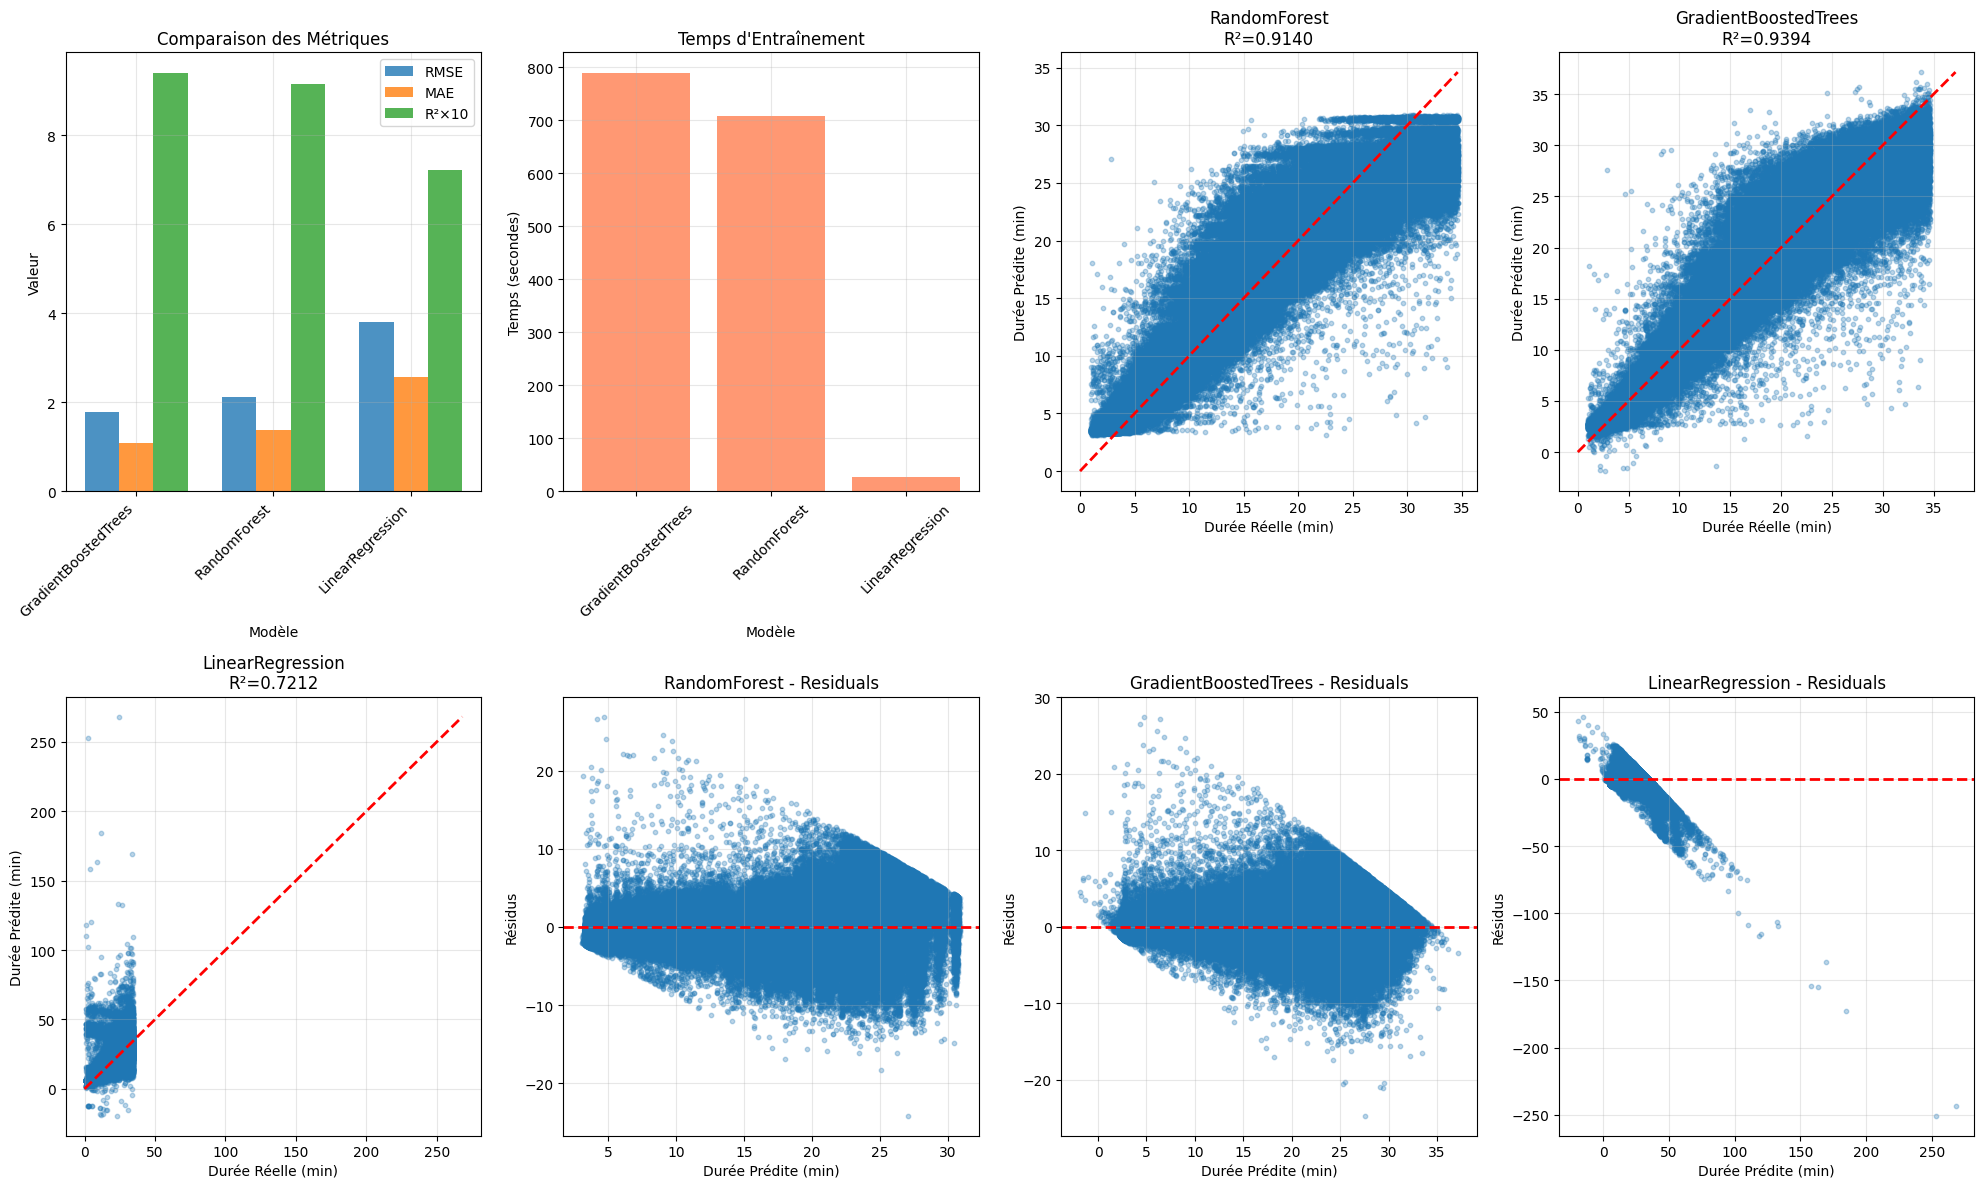

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ============================================
# 1. CHARGEMENT DES DONNÉES
# ============================================

print("📊 Chargement des données depuis PostgreSQL...")

# PostgreSQL connection details
jdbc_url = "jdbc:postgresql://localhost:5432/silver_data"
connection_properties = {
    "user": "silver_user",
    "password": "silver_pass123",
    "driver": "org.postgresql.Driver"
}

# Charger les données
df = spark.read.jdbc(
    url=jdbc_url,
    table="silver_table",
    properties=connection_properties
)

print(f"✅ Données chargées: {df.count():,} lignes")
print(f"📋 Colonnes: {df.columns}")
df.printSchema()

# ============================================
# 2. IDENTIFICATION DES FEATURES (UPDATED)
# ============================================

# Features numériques continues (à normaliser)
numerical_features = [
    'passenger_count',
    'trip_distance',
    'PULocationID',
    'DOLocationID',
    'fare_amount',
    'tip_amount',
    'tolls_amount',
    'Airport_fee',
    'pickup_hour'
]

# Features catégorielles (à encoder)
categorical_features = [
    'RatecodeID'
]

# Target
target_column = 'trip_duration'

all_features = numerical_features + categorical_features

print(f"\n🎯 CONFIGURATION DES FEATURES:")
print(f"   Numériques: {len(numerical_features)} features")
print(f"   Catégorielles: {len(categorical_features)} features")
print(f"   Target: {target_column}")

# ============================================
# 5. SPLIT TRAIN/TEST
# ============================================

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
train_df = train_df.cache()
test_df = test_df.cache()

print(f"\n📊 SPLIT DES DONNÉES:")
print(f"   Train: {train_df.count():,} lignes ({train_df.count()/df.count()*100:.1f}%)")
print(f"   Test:  {test_df.count():,} lignes ({test_df.count()/df.count()*100:.1f}%)")

# ============================================
# 6. CRÉATION DES PIPELINES PREPROCESSING
# ============================================

print("\n🔧 CRÉATION DES STAGES DE PREPROCESSING...")

def create_preprocessing_stages():
    """Crée les stages de preprocessing réutilisables"""
    stages = []
    
    # ÉTAPE 1: Encoder RatecodeID
    indexer = StringIndexer(
        inputCol='RatecodeID',
        outputCol='RatecodeID_indexed',
        handleInvalid='keep'
    )
    stages.append(indexer)
    
    encoder = OneHotEncoder(
        inputCols=['RatecodeID_indexed'],
        outputCols=['RatecodeID_encoded'],
        dropLast=True
    )
    stages.append(encoder)
    
    # ÉTAPE 2: Assembler features numériques
    numerical_assembler = VectorAssembler(
        inputCols=numerical_features,
        outputCol='numerical_features_vec',
        handleInvalid='skip'
    )
    stages.append(numerical_assembler)
    
    # ÉTAPE 3: Normaliser
    scaler = StandardScaler(
        inputCol='numerical_features_vec',
        outputCol='numerical_features_scaled',
        withMean=True,
        withStd=True
    )
    stages.append(scaler)
    
    # ÉTAPE 4: Assembler toutes les features
    final_assembler = VectorAssembler(
        inputCols=['numerical_features_scaled', 'RatecodeID_encoded'],
        outputCol='features',
        handleInvalid='skip'
    )
    stages.append(final_assembler)
    
    return stages

# ============================================
# 7. DÉFINITION DES MODÈLES
# ============================================

print("\n🤖 CONFIGURATION DES MODÈLES...")

models = {
    'RandomForest': RandomForestRegressor(
        featuresCol='features',
        labelCol=target_column,
        predictionCol='prediction',
        numTrees=100,
        maxDepth=10,
        minInstancesPerNode=5,
        subsamplingRate=0.8,
        featureSubsetStrategy='sqrt',
        seed=42
    ),
    
    'GradientBoostedTrees': GBTRegressor(
        featuresCol='features',
        labelCol=target_column,
        predictionCol='prediction',
        maxIter=100,
        maxDepth=8,
        stepSize=0.1,
        subsamplingRate=0.8,
        featureSubsetStrategy='sqrt',
        seed=42
    ),
    
    'LinearRegression': LinearRegression(
        featuresCol='features',
        labelCol=target_column,
        predictionCol='prediction',
        maxIter=100,
        regParam=0.1,
        elasticNetParam=0.5,
        standardization=False  # Already scaled
    )
}

print(f"✅ {len(models)} modèles configurés: {list(models.keys())}")

# ============================================
# 8. ENTRAÎNEMENT ET ÉVALUATION
# ============================================

results = {}
trained_models = {}

for model_name, model in models.items():
    print(f"\n{'='*70}")
    print(f"🚀 ENTRAÎNEMENT: {model_name}")
    print(f"{'='*70}")
    
    # Créer le pipeline
    preprocessing_stages = create_preprocessing_stages()
    pipeline = Pipeline(stages=preprocessing_stages + [model])
    
    # Entraîner
    start_time = datetime.now()
    trained_model = pipeline.fit(train_df)
    training_time = (datetime.now() - start_time).total_seconds()
    
    print(f"⏱️  Temps d'entraînement: {training_time:.2f}s")
    
    # Prédire
    predictions = trained_model.transform(test_df)
    
    # Évaluer
    evaluator_rmse = RegressionEvaluator(
        labelCol=target_column,
        predictionCol='prediction',
        metricName='rmse'
    )
    evaluator_mae = RegressionEvaluator(
        labelCol=target_column,
        predictionCol='prediction',
        metricName='mae'
    )
    evaluator_r2 = RegressionEvaluator(
        labelCol=target_column,
        predictionCol='prediction',
        metricName='r2'
    )
    
    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    
    print(f"\n📈 MÉTRIQUES:")
    print(f"   RMSE: {rmse:.2f} minutes")
    print(f"   MAE:  {mae:.2f} minutes")
    print(f"   R²:   {r2:.4f}")
    
    # Sauvegarder les résultats
    results[model_name] = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'training_time': training_time,
        'predictions': predictions
    }
    trained_models[model_name] = trained_model

# ============================================
# 9. COMPARAISON DES MODÈLES
# ============================================

print(f"\n{'='*70}")
print("📊 COMPARAISON DES MODÈLES")
print(f"{'='*70}")

comparison_df = pd.DataFrame({
    'Modèle': list(results.keys()),
    'RMSE': [results[m]['rmse'] for m in results.keys()],
    'MAE': [results[m]['mae'] for m in results.keys()],
    'R²': [results[m]['r2'] for m in results.keys()],
    'Temps (s)': [results[m]['training_time'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('RMSE')
print(comparison_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]['Modèle']
print(f"\n🏆 MEILLEUR MODÈLE: {best_model_name}")



In [ ]:
# ============================================
# 12. SAUVEGARDE DU MEILLEUR MODÈLE
# ============================================

print(f"\n💾 SAUVEGARDE DU MEILLEUR MODÈLE: {best_model_name}...")

best_model = trained_models[best_model_name]
model_path = f"/opt/airflow/models/{best_model_name.lower()}_model_spark"
best_model.write().overwrite().save(model_path)
print(f"✅ Modèle sauvegardé: {model_path}")



